In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(DESeq2)
library(phyloseq)
library(plyr); library(dplyr)
library(ggplot2)
library(doParallel)
library(foreach)
library(reshape)
library(RColorBrewer)
library(gridExtra)
library(stats)
library(data.table)
library(compare, lib.loc="/home/ashley/R/x86_64-pc-linux-gnu-library/3.1/")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package:

###This file is from the [l2fc sparsity notebook](./Sparsity_make_l2fc_table.ipynb) 

In [4]:
%%R
l2fc.filtered = read.csv("data/l2fc_table.csv")

In [5]:
%%R
head(l2fc.filtered)

  sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1               0.45  14      13CC OTU.4204    -0.20588818 0.9999657 Bacteria
2               0.45  14      13CC  OTU.467    -0.30402392 0.9999980 Bacteria
3               0.45  14      13CC  OTU.905     0.08372895 0.9763679 Bacteria
4               0.45  14      13CC OTU.7253     0.12803079 0.9657952 Bacteria
5               0.45  14      13CC   OTU.67    -0.52084841 0.9999991 Bacteria
6               0.45  14      13CC OTU.4907     0.14386449 0.9994238 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria DA023 

In [6]:
%%R
FDR = 0.10

d1 = l2fc.filtered %>%
    #filter(Treatment %in% c("13CC", "13C100")) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = sum(minP <= FDR)) #%>%
d1

Source: local data frame [495 x 2]

         OTU rspnse
1      OTU.1      1
2     OTU.10      3
3  OTU.10036      1
4   OTU.1009      2
5    OTU.101      1
6   OTU.1016      1
7  OTU.10167      3
8  OTU.10192      1
9    OTU.102      3
10 OTU.10228      2
..       ...    ...


In [7]:
%%R
d2 = subset(d1, rspnse == 3)
d2

Source: local data frame [136 x 2]

         OTU rspnse
1     OTU.10      3
2  OTU.10167      3
3    OTU.102      3
4   OTU.1032      3
5   OTU.1041      3
6  OTU.10638      3
7    OTU.109      3
8    OTU.111      3
9    OTU.121      3
10  OTU.1214      3
..       ...    ...


In [8]:
%%R
FDR = 0.10

f = function(x) {
    if (x <= FDR) {
        return("yes")
    } else {
        return ("no")
    }
}

l2fc.filtered$padj.cat = sapply(l2fc.filtered$padj, f)
head(l2fc.filtered)

  sparsity_threshold Day Treatment      OTU log2FoldChange         p    Rank1
1               0.45  14      13CC OTU.4204    -0.20588818 0.9999657 Bacteria
2               0.45  14      13CC  OTU.467    -0.30402392 0.9999980 Bacteria
3               0.45  14      13CC  OTU.905     0.08372895 0.9763679 Bacteria
4               0.45  14      13CC OTU.7253     0.12803079 0.9657952 Bacteria
5               0.45  14      13CC   OTU.67    -0.52084841 0.9999991 Bacteria
6               0.45  14      13CC OTU.4907     0.14386449 0.9994238 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria DA023 

In [11]:
%%R
shared.resp = left_join(d2, l2fc.filtered, by = "OTU")
shared.resp

Source: local data frame [1,171 x 17]

         OTU rspnse sparsity_threshold Day Treatment log2FoldChange
1     OTU.10      3               0.45  14      13CC      3.3105565
2     OTU.10      3               0.45  28      13CC      1.9391412
3     OTU.10      3               0.45  45      13CC      3.1312454
4     OTU.10      3               0.45  14    13C100      2.5840326
5     OTU.10      3               0.45  28    13C100      3.2116725
6     OTU.10      3               0.45  45    13C100      2.9204350
7     OTU.10      3               0.45  14    13C700      4.1889022
8     OTU.10      3               0.45  28    13C700      2.3747727
9     OTU.10      3               0.45  45    13C700      2.7298395
10 OTU.10167      3               0.45  14      13CC      0.5159896
..       ...    ...                ... ...       ...            ...
Variables not shown: p (dbl), Rank1 (fctr), Rank2 (fctr), Rank3 (fctr), Rank4
  (fctr), Rank5 (fctr), Rank6 (fctr), Rank7 (fctr), Rank8 (fctr), p

In [ ]:
%%R
d1 = d1 %>%
    mutate(rspnse.t = ifelse(rspnse == 3, "All", "no"))

r = function(x) {
    if(rspnse == 3) {
        return("All")
    } else {
    tot.price <- net.price * 1.06
} else {
    tot.price <- net.price
}
    
l2fc.filtered$padj.cat = sapply(l2fc.filtered$padj, f)

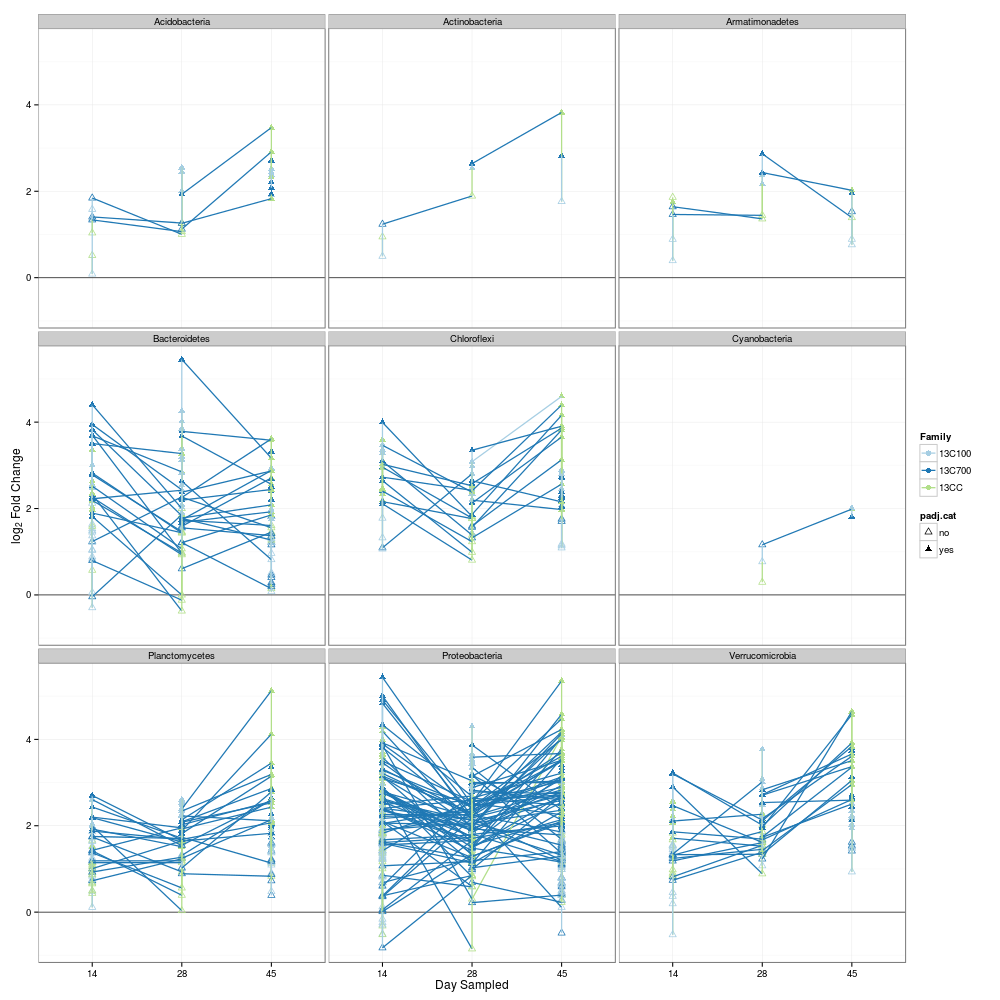

In [12]:
%%R -h 1000 -w 1000

colourCount = length(unique(shared.resp$Rank2))
getPalette = colorRampPalette(brewer.pal(colourCount, "Paired"))

p = ggplot(shared.resp, aes(x = factor(Day), y = log2FoldChange, group = OTU, 
                            color = Treatment, shape = padj.cat))

p = p + geom_hline(y = 0, color = "grey20", size = 0.4)

p = p + geom_point(size = 2.5) 

p = p + geom_line(size = 0.6)

p = p + scale_shape_manual(values = c(2, 17))
#p = p + geom_point(data=p, mapping=aes(x=p%%16, y=p%/%16, shape=p), size=5, fill="red")

p = p + labs(x = "Day Sampled",
             y = expression(paste("", log[2], " Fold Change", sep = "")),
             color = "Family")

p = p + theme_bw()

p = p + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p = p + facet_wrap(~Rank2)

p

In [7]:
%%R
FDR = 0.10

d1 = l2fc.filtered %>%
    #filter(Treatment %in% c("13CC", "13C100")) %>%
    group_by(OTU, Treatment, Rank2) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by(OTU) %>%
    summarize(rspnse = sum(minP <= FDR)) #%>%
d1

Source: local data frame [495 x 2]

         OTU rspnse
1      OTU.1      1
2     OTU.10      3
3  OTU.10036      1
4   OTU.1009      2
5    OTU.101      1
6   OTU.1016      1
7  OTU.10167      3
8  OTU.10192      1
9    OTU.102      3
10 OTU.10228      2
..       ...    ...


In [ ]:
%%R
d1 = d1 %>%
    mutate(rspnse.t = ifelse(rspnse == 3, "All", "no"))

if(client=='private'){
    tot.price <- net.price * 1.12
} else if(client=='public'){
    tot.price <- net.price * 1.06
} else {
    tot.price <- net.price
}

In [ ]:
%%R

df.all.l2fc = read.table("data/l2fc_table.csv",
                         sep = ",", header = TRUE)
#sample.data$treatment = as.character(sample.data$treatment)
head(df.all.l2fc)

In [ ]:
%%R

asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("../data/fungal_otu_table_wtax.biom")
sample.data = import_qiime_sample_data("../data/metadata_fungi.txt")
sample.data$Density = asNumeric(sample.data$Density)
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& 
                             (physeq.md$SampleID != c("D312.6")),  physeq)
physeq = prune_samples(sample_sums(physeq) > 5360, physeq)

print(physeq)

In [ ]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("data/allsample_metadata_nomock_amendment2.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)

In [ ]:
%%R -h 500 -w 1100

p = ggplot(d_asco_basi, aes(x = factor(Day), y = log2FoldChange, group = OTU, 
                            color = color_taxon, shape = p.adj.cat))

colourCount = length(unique(d_asco_basi$color_taxon))
getPalette = colorRampPalette(brewer.pal(colourCount, "Spectral"))

p = p + geom_hline(y = 0, color = "grey20", size = 0.4)

p = p + geom_point(size = 4) 

p = p + geom_line(size = 0.6)

p = p + scale_shape_manual(values = c(17,2))
#p = p + geom_point(data=p, mapping=aes(x=p%%16, y=p%/%16, shape=p), size=5, fill="red")

p = p + labs(x = "Day Sampled",
             y = expression(paste("", log[2], " Fold Change", sep = "")),
             color = "Taxa", 
             shape = "Significant")

p = p + theme_bw()

p = p + theme(strip.text.x = element_text(size = 14), 
 #             strip.background = element_blank(),
              axis.text.x = element_text(size = 14), 
              legend.title = element_text(size = 12), 
             axis.title = element_text(size = 14))

p = p + scale_color_manual(values = getPalette(colourCount), na.value = "grey50")

p = p + facet_wrap(~filter_taxon)

#p = p + geom_hline(y = 1.99)

p

In [ ]:
%%R
ggsave("../figs/cell_fung_ascobasid_l2fc_byday.pdf", asco_basi, h = 7.5, w = 18)

In [ ]:
FileLink("figs/.pdf")